# Illustration of that the Hay model has stationary dipole

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import LFPy
from brainsignals.plotting_convention import mark_subplots, cmap_v_e
from brainsignals.neural_simulations import return_hay_cell

np.random.seed(12345)

# Create a grid of measurement locations, in (um)
grid_x, grid_z = np.mgrid[-650:651:20, -700:1600:20]
grid_y = np.ones(grid_x.shape) * 0

sigma = 0.3  # S/m

# Define electrode parameters
grid_elec_params = {
    'sigma': sigma,      # extracellular conductivity
    'x': grid_x.flatten(),  # electrode positions
    'y': grid_y.flatten(),
    'z': grid_z.flatten(),
    'method': 'linesource'
}



### Running all simulations

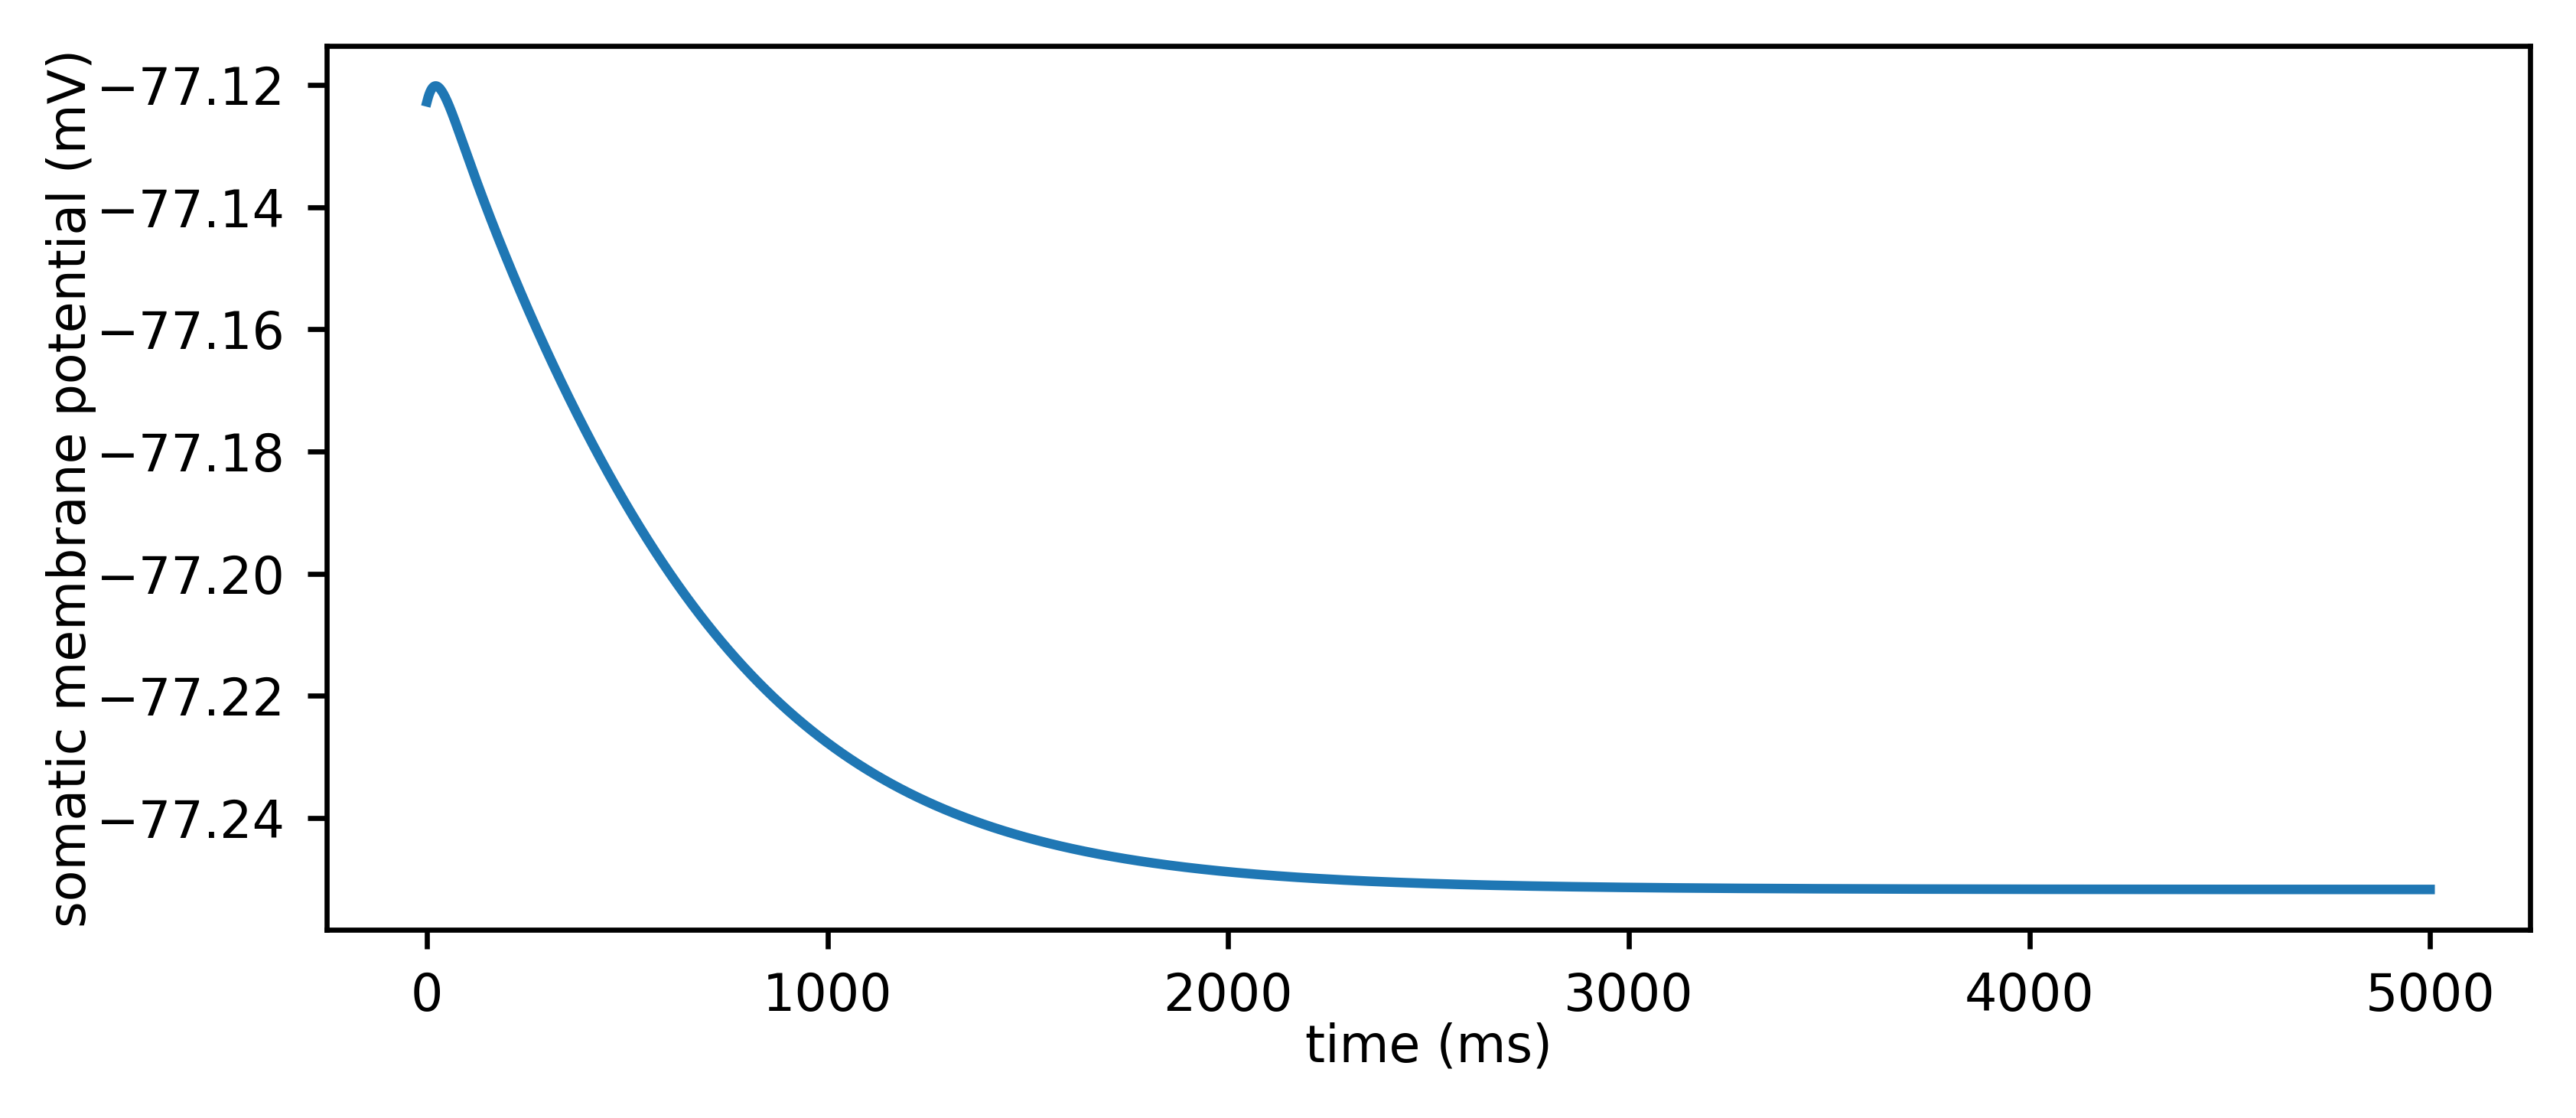

In [2]:
tstop = 5000
dt = 2**-4

cell = return_hay_cell(tstop=tstop, dt=dt, make_passive=False)
grid_electrode = LFPy.RecExtElectrode(cell, **grid_elec_params)

cell.simulate(rec_imem=True)
plt.plot(cell.tvec, cell.somav)
plt.xlabel("time (ms)")
plt.ylabel("somatic membrane potential (mV)")
t_idx = -1
cell.imem = cell.imem[:, t_idx:]
LFP = 1000 * grid_electrode.get_transformation_matrix() @ cell.imem


### Plotting results

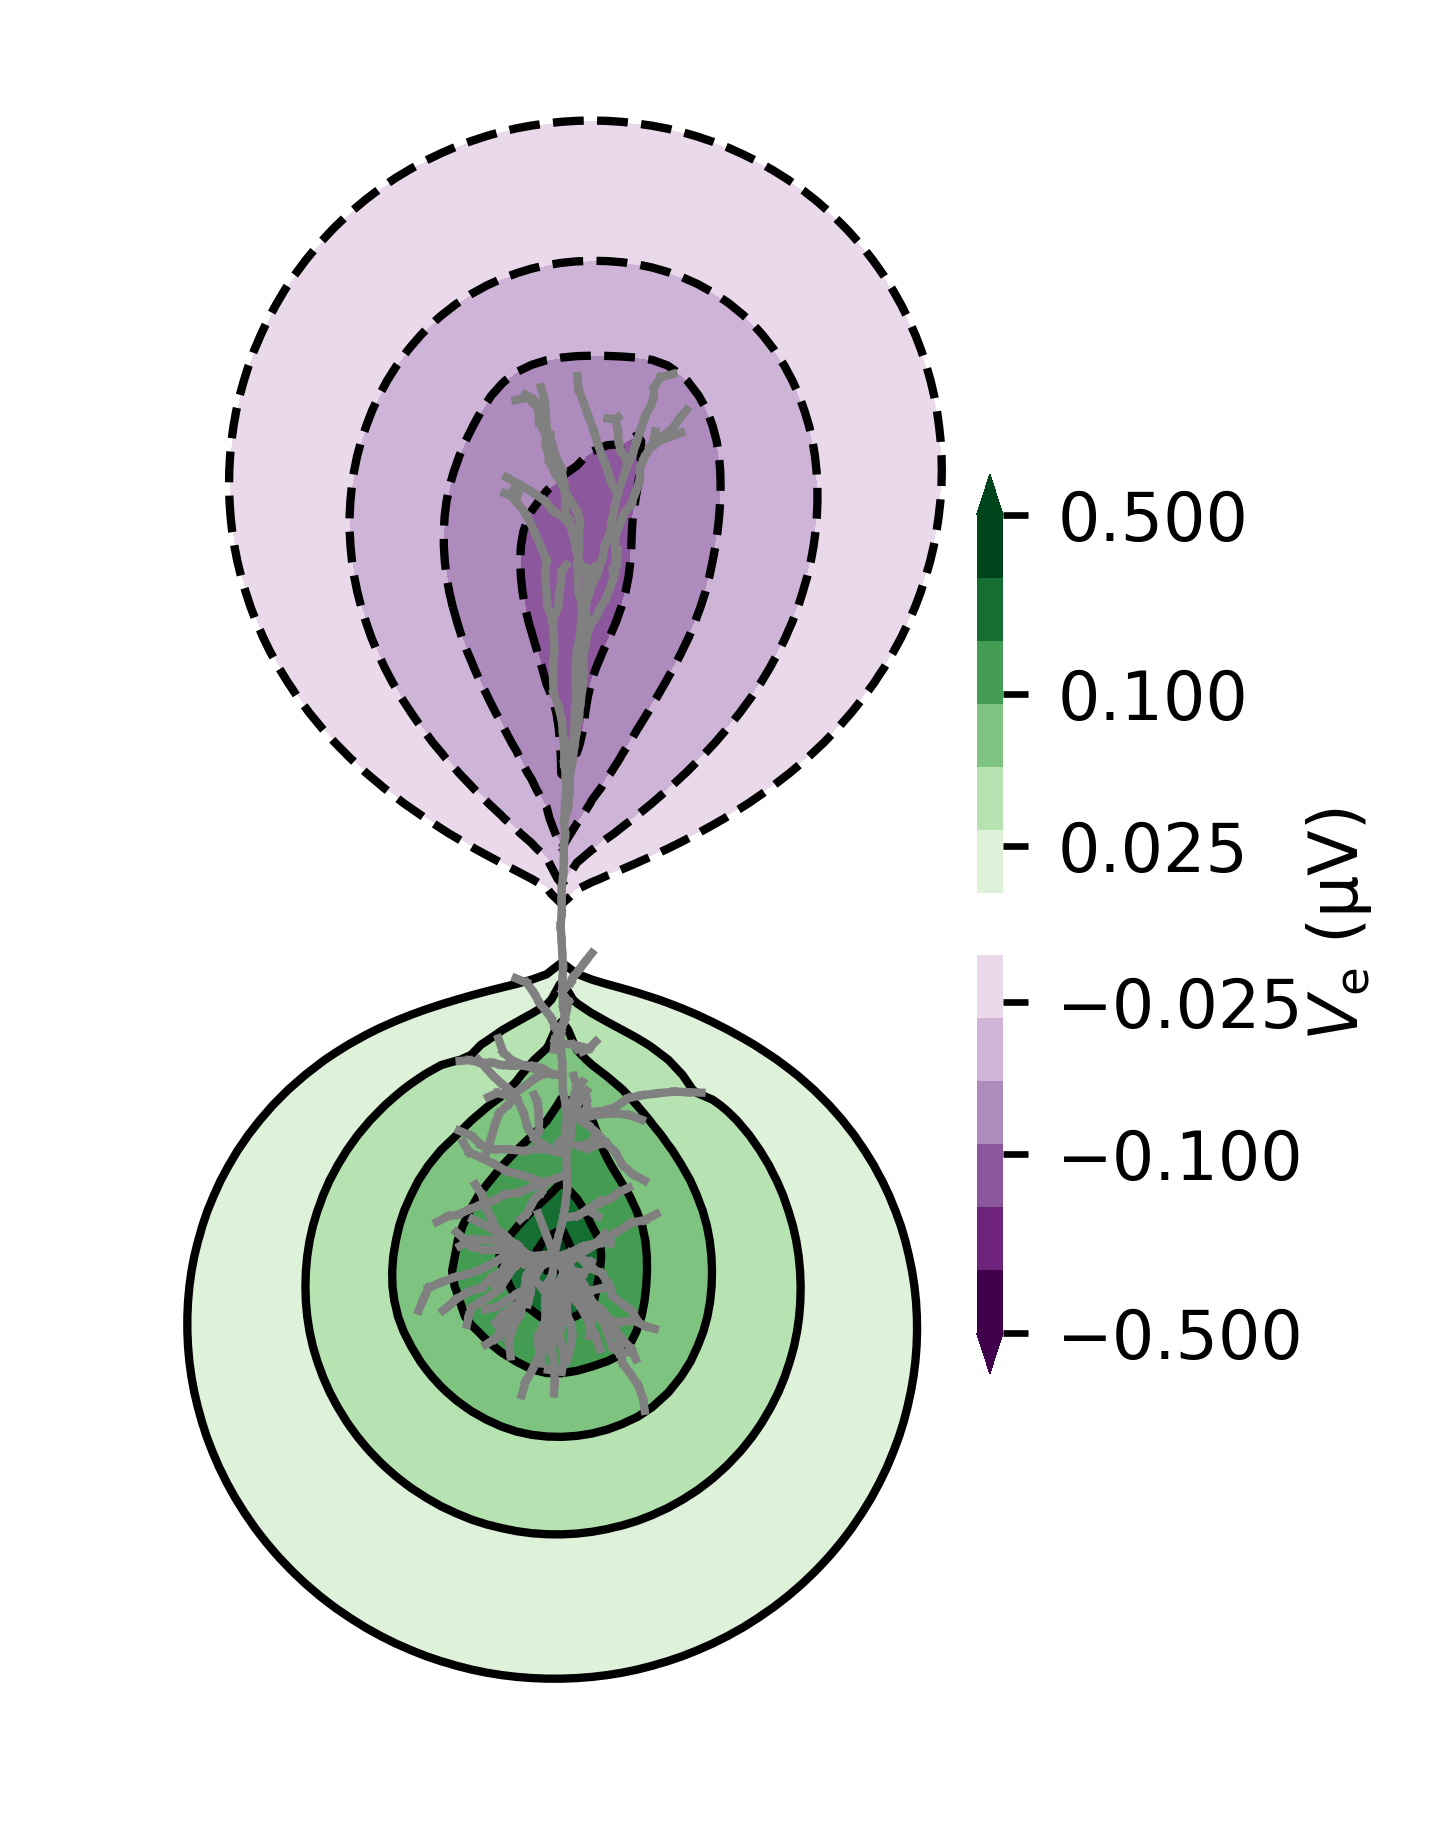

In [3]:

ax_lfp_dict = dict(aspect=1, frameon=False, xticks=[], yticks=[],
                   ylim=[np.min(grid_z) - 5, np.max(grid_z) + 5],
                   xlim=[np.min(grid_x) - 5, np.max(grid_x) + 5])
    
plt.close("all")
fig = plt.figure(figsize=[2.2, 3])
fig.subplots_adjust(bottom=0.02, top=0.98, right=0.85,
                    left=-0.15, wspace=-0.0, hspace=-0.1)

ax = fig.add_subplot(111, **ax_lfp_dict)

max_amp_LFP = np.max(np.abs(LFP[:, 0]))

LFP_grid = LFP[:, 0].reshape(grid_x.shape)
num = 7
levels = np.logspace(-1.5, 0, num=num)

scale_max = 0.5#np.max(np.abs(LFP))

levels_norm = scale_max * np.concatenate((-levels[::-1], levels))

colors_from_map = [cmap_v_e(i/(len(levels_norm) - 2))
                   for i in range(len(levels_norm) -1)]
colors_from_map[num - 1] = (1.0, 1.0, 1.0, 1.0)

img = ax.contourf(grid_x, grid_z, LFP_grid,
                               zorder=2, colors=colors_from_map,
                               levels=levels_norm, extend='both')

ax.contour(grid_x, grid_z, LFP_grid, colors='k', linewidths=(1), zorder=2,
               levels=levels_norm)

ax.plot(cell.x.T, cell.z.T, lw=1, c='gray')
cax = fig.add_axes([0.67, 0.25, 0.02, 0.5], frameon=False)
cbar = fig.colorbar(img, cax=cax, orientation='vertical')
cbar.set_label('$V_{\mathrm{e}}$ (µV)', labelpad=0)
cbar.set_ticks(np.array([-1, -0.2, -0.05, 0.05, 0.2, 1]) * scale_max)

fig.savefig("fig_hay_stationary_dipole.pdf")

### Test for population

Population radius:  141.0 µm


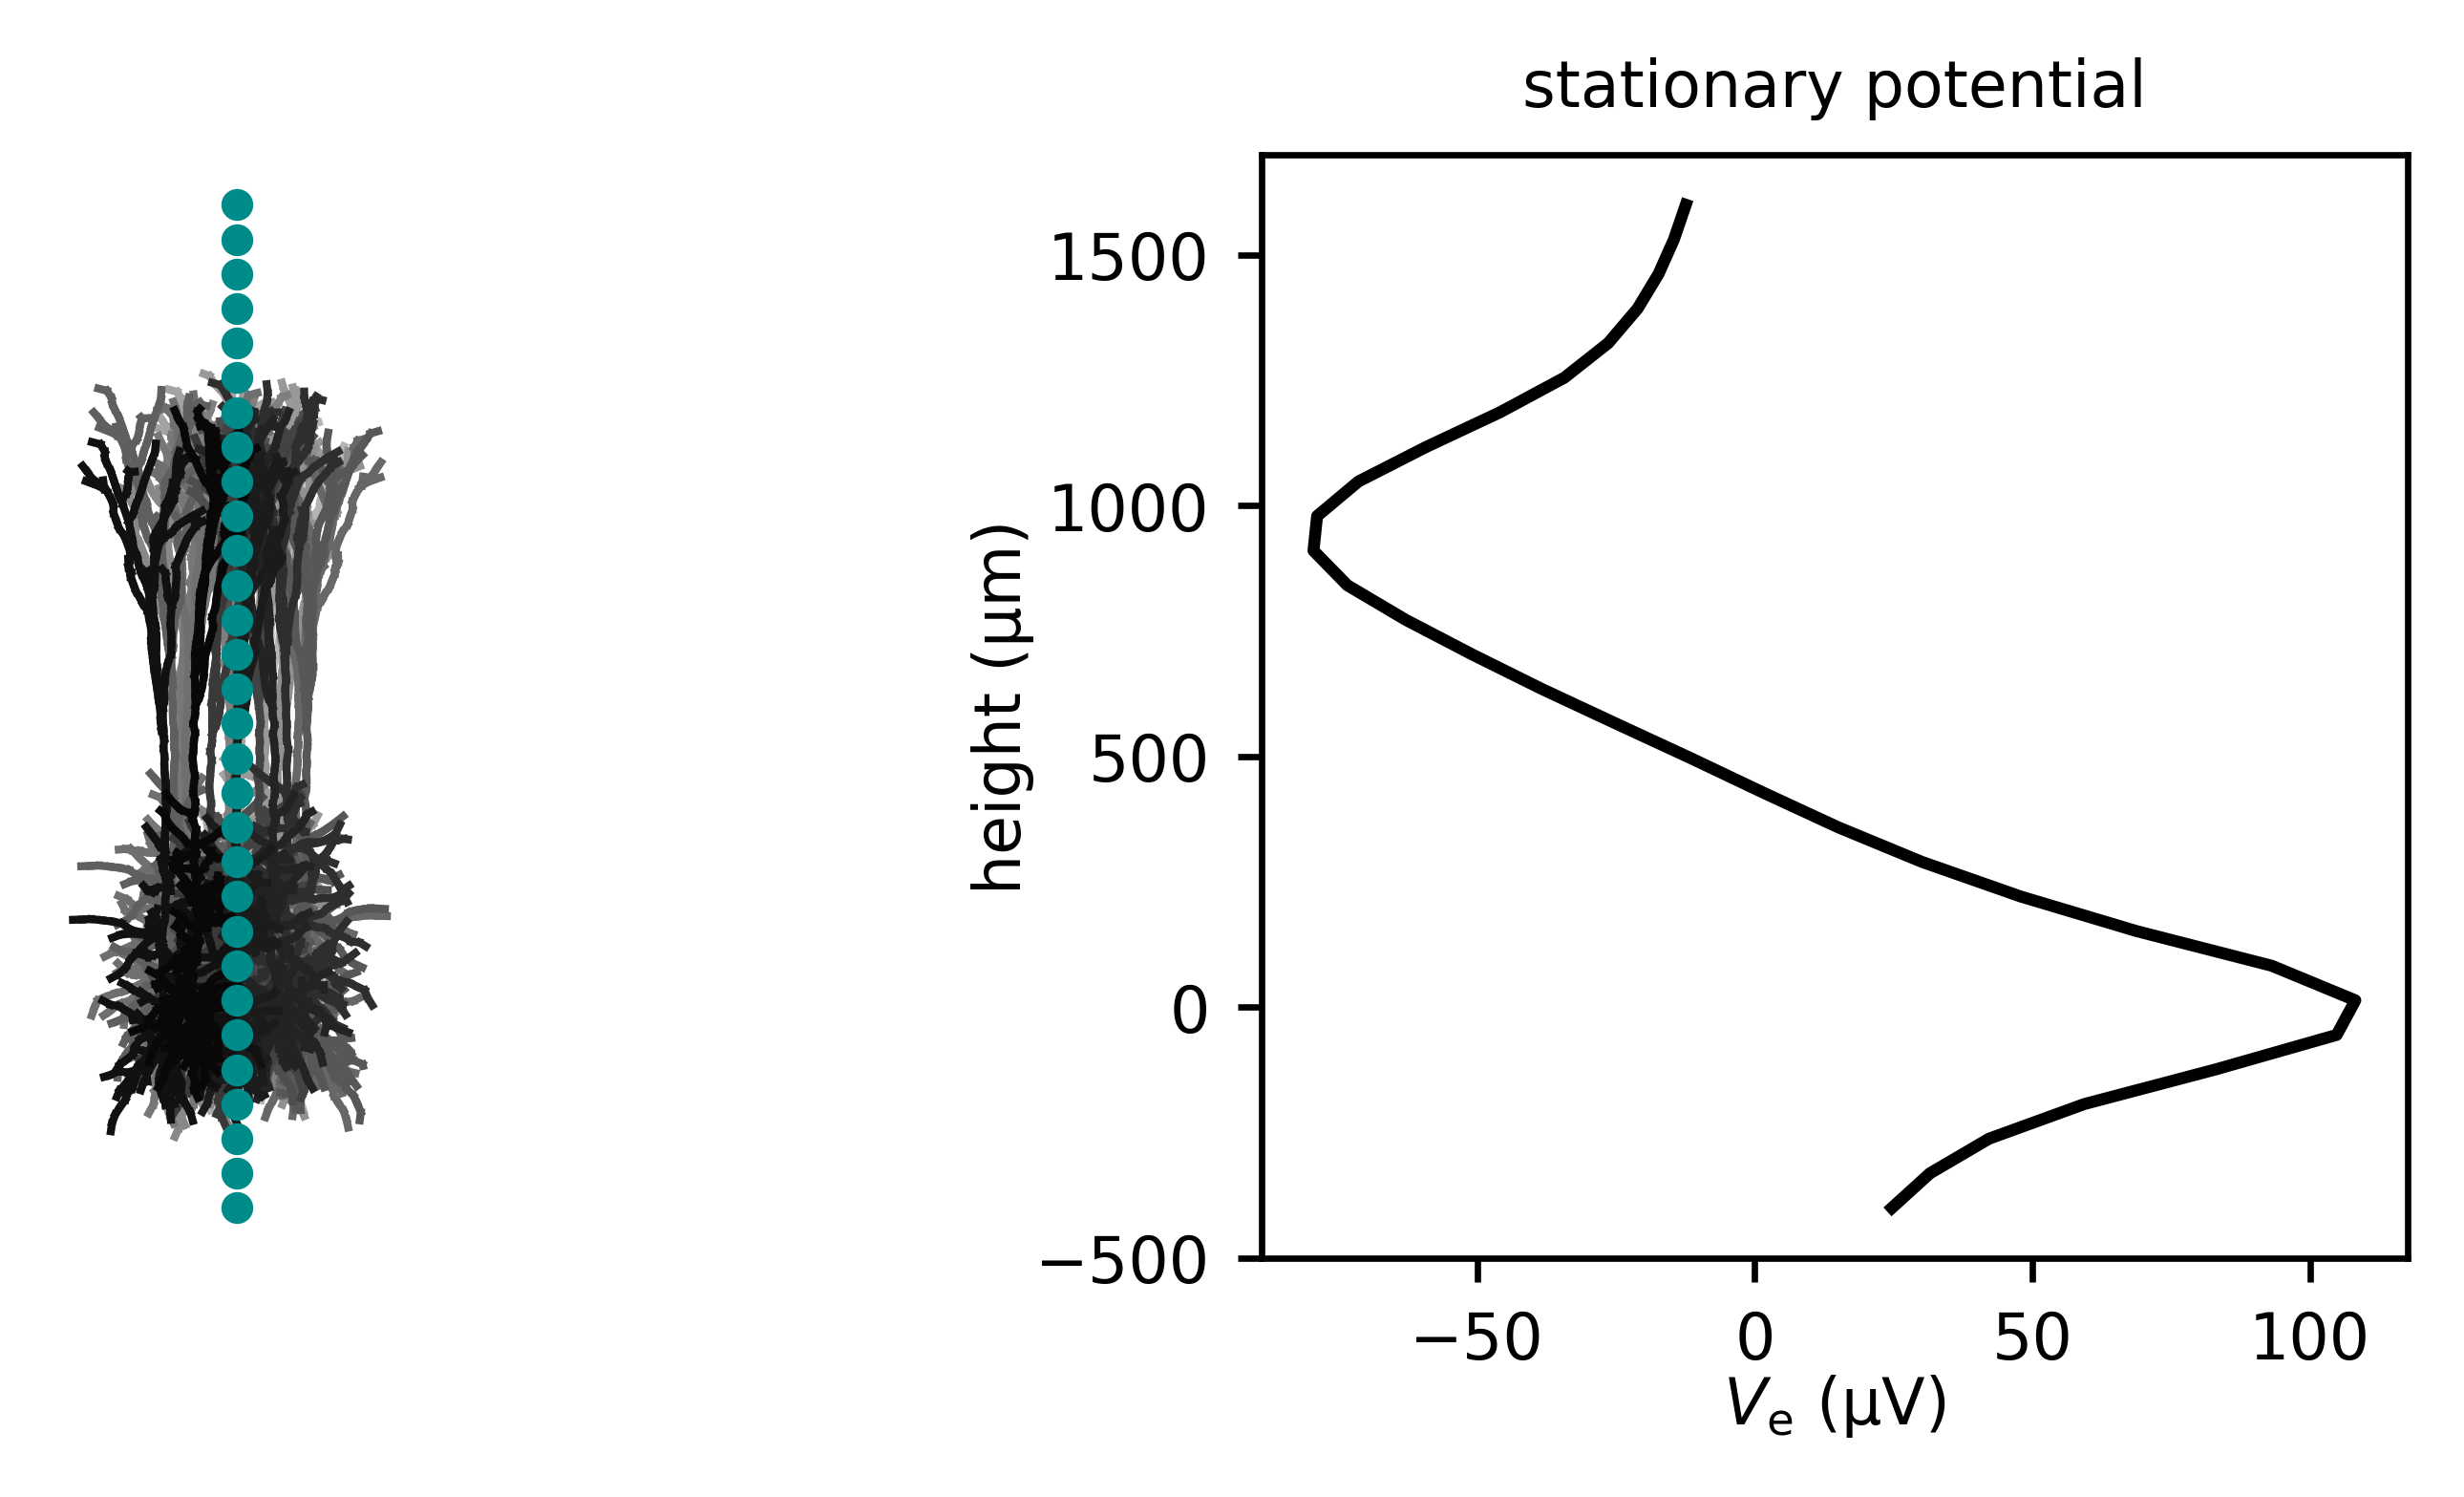

In [4]:
# Define electrode parameters
num_elecs = 30
elec_params = {
    'sigma': sigma,      # extracellular conductivity
    'x': np.zeros(num_elecs),  # electrode positions
    'y': np.zeros(num_elecs),
    'z': np.linspace(-400, 1600, num_elecs),
    'method': 'linesource'
}

num_cells = 1000
pop_height = 200  # µm
cell_density = 80000 * 1e-9 # cells / mm³
pop_radius = np.sqrt(num_cells / (cell_density * np.pi * pop_height))

rs = pop_radius * np.sqrt(np.random.rand(num_cells))
theta = np.random.uniform(0, 2 * np.pi, num_cells)
pop_xs = rs * np.cos(theta)
pop_ys = rs * np.sin(theta)
pop_zs = np.random.uniform(-pop_height/2, pop_height/2, num_cells)
cell_rots = np.random.uniform(0, 2 * np.pi, num_cells)

print(f"Population radius: {pop_radius: 1.1f} µm")

lfp_dc = np.zeros(num_elecs)

fig = plt.figure()
ax1 = fig.add_subplot(121, aspect=1, frameon=False, xticks=[], yticks=[])
ax2 = fig.add_subplot(122, xlabel="$V_{\mathrm{e}}$ (µV)", ylabel="height (µm)", title="stationary potential")
num_cells_to_plot = 20
cell_clrs = lambda idx: plt.cm.Greys(0.4 + idx / num_cells_to_plot * 0.6)
for cell_idx in range(num_cells):
    cell.set_pos(x=pop_xs[cell_idx], y=pop_ys[cell_idx], z=pop_zs[cell_idx])
    cell.set_rotation(z=cell_rots[cell_idx])
    electrode = LFPy.RecExtElectrode(cell, **elec_params)
    LFP = 1000 * electrode.get_transformation_matrix() @ cell.imem[:, -1]
    lfp_dc += LFP
    if cell_idx < num_cells_to_plot:
        ax1.plot(cell.x.T, cell.z.T, c=cell_clrs(cell_idx), lw=1)
    
ax2.plot(lfp_dc, elec_params["z"], c='k')
ax1.plot(elec_params["x"], elec_params["z"], 'o', ms=3, c='darkcyan');